 **1. Importing Libaries**

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')
import pickle

**2. Data Loading & Understanding**

In [3]:
# Read CSV data
df = pd.read_csv('/content/train.csv')

In [4]:
# The AQ-10 test has reverse-scored questions.
# Questions 1, 7, 8, 10 are scored 1 for "Agree".
# Questions 2, 3, 4, 5, 6, 9 are scored 1 for "Disagree".
# Your original data seems to represent "Agree" as 1 and "Disagree" as 0.
# We need to flip the scores for the reverse-scored questions.

reverse_scored_cols = ['A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A9_Score']
for col in reverse_scored_cols:
    # Flip the values: 0 becomes 1, and 1 becomes 0
    df[col] = df[col].apply(lambda x: 1 - x)

Initial Inspection

In [5]:
df.shape

(800, 22)

In [6]:
df.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,1,0,0,0,0,0,1,0,...,f,White-European,no,no,United States,no,7.819715,18 and more,Self,0
1,2,0,1,1,1,1,1,0,0,1,...,f,South Asian,no,no,Australia,no,10.544296,18 and more,?,0
2,3,1,0,0,0,0,0,0,0,0,...,f,White-European,no,no,United Kingdom,no,13.167506,18 and more,Self,1
3,4,0,1,1,0,1,1,0,0,1,...,f,South Asian,no,no,New Zealand,no,1.530098,18 and more,?,0
4,5,0,1,1,1,0,1,0,0,0,...,m,Black,no,yes,Italy,no,7.949723,18 and more,Self,0


In [7]:
# Display all columns of a dataframe
pd.set_option('display.max_columns', None)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               800 non-null    int64  
 1   A1_Score         800 non-null    int64  
 2   A2_Score         800 non-null    int64  
 3   A3_Score         800 non-null    int64  
 4   A4_Score         800 non-null    int64  
 5   A5_Score         800 non-null    int64  
 6   A6_Score         800 non-null    int64  
 7   A7_Score         800 non-null    int64  
 8   A8_Score         800 non-null    int64  
 9   A9_Score         800 non-null    int64  
 10  A10_Score        800 non-null    int64  
 11  age              800 non-null    float64
 12  gender           800 non-null    object 
 13  ethnicity        800 non-null    object 
 14  jaundice         800 non-null    object 
 15  austim           800 non-null    object 
 16  contry_of_res    800 non-null    object 
 17  used_app_before 

In [9]:
# convert age column to integer
df['age'] = df['age'].astype(int)

In [10]:
df.head(1)

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,1,0,0,0,0,0,1,0,1,18,f,White-European,no,no,United States,no,7.819715,18 and more,Self,0


In [11]:
for col in df.columns:
  numerical_columns = ['ID','age','result']
  if col not in numerical_columns:
    print(col, df[col].unique())
    print('*'*60)

A1_Score [1 0]
************************************************************
A2_Score [1 0]
************************************************************
A3_Score [0 1]
************************************************************
A4_Score [0 1]
************************************************************
A5_Score [0 1]
************************************************************
A6_Score [0 1]
************************************************************
A7_Score [0 1]
************************************************************
A8_Score [1 0]
************************************************************
A9_Score [0 1]
************************************************************
A10_Score [1 0]
************************************************************
gender ['f' 'm']
************************************************************
ethnicity ['White-European' 'South Asian' 'Black' 'Asian' 'Middle Eastern ' '?'
 'others' 'Latino' 'Turkish' 'Others' 'Hispanic' 'Pasifika']
********************

In [12]:
# dropping id and age_dsc columns
df = df.drop(['ID','age_desc'], axis=1)

In [13]:
# mapping wrong country names
mapping = {
    'Viet Nam': 'Vietnam',
    'AmericanSamoa': 'United States',
    'Hong Kong': 'China'
}

df['contry_of_res'] = df['contry_of_res'].replace(mapping)

In [14]:
df['contry_of_res'].unique()

array(['United States', 'Australia', 'United Kingdom', 'New Zealand',
       'Italy', 'Nicaragua', 'Canada', 'United Arab Emirates',
       'Netherlands', 'Sri Lanka', 'India', 'Armenia', 'Sierra Leone',
       'Argentina', 'Azerbaijan', 'Iceland', 'Egypt', 'Serbia',
       'Afghanistan', 'Costa Rica', 'Jordan', 'Angola', 'Pakistan',
       'Brazil', 'Ireland', 'Kazakhstan', 'Vietnam', 'Ethiopia',
       'Austria', 'Finland', 'France', 'Malaysia', 'Japan', 'Spain',
       'Philippines', 'Iran', 'Czech Republic', 'Russia', 'Romania',
       'Mexico', 'Belgium', 'Aruba', 'Uruguay', 'Indonesia', 'Ukraine',
       'Germany', 'China', 'Iraq', 'Tonga', 'South Africa',
       'Saudi Arabia', 'Bahamas', 'Ecuador', 'Cyprus', 'Bangladesh',
       'Oman', 'Bolivia', 'Sweden', 'Niger'], dtype=object)

In [15]:
# target class distribution
df['Class/ASD'].value_counts()

,count
Class/ASD,
0,615
1,185


**Insights**
1. missing values(?) on relations and ethnicity.
2. age_dsc column have only one unique value so it is dropped.
3. Corrected Country names
4. Handled Class imbalance

**Exploratory Data Analysis(EDA)**

In [16]:
df.shape

(800, 20)

In [17]:
df.columns

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender',
       'ethnicity', 'jaundice', 'austim', 'contry_of_res', 'used_app_before',
       'result', 'relation', 'Class/ASD'],
      dtype='object')

In [18]:
df.head(3)

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,relation,Class/ASD
0,1,1,0,0,0,0,0,1,0,1,18,f,White-European,no,no,United States,no,7.819715,Self,0
1,0,1,1,1,1,1,0,0,1,1,13,f,South Asian,no,no,Australia,no,10.544296,?,0
2,1,0,0,0,0,0,0,0,0,1,14,f,White-European,no,no,United Kingdom,no,13.167506,Self,1


In [19]:
df.describe()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,result,Class/ASD
count,800.000000,800.00000,800.000000,800.00000,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.00000,800.000000,800.000000
mean,0.582500,0.71375,0.678750,0.58500,0.542500,0.79125,0.273750,0.717500,0.683750,0.460000,28.11500,7.058530,0.231250
std,0.493455,0.45229,0.467249,0.49303,0.498502,0.40667,0.446161,0.450497,0.465303,0.498709,12.88611,3.788969,0.421896
min,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,9.00000,-2.594654,0.000000
25%,0.000000,0.00000,0.000000,0.00000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,19.00000,4.527556,0.000000
50%,1.000000,1.00000,1.000000,1.00000,1.000000,1.00000,0.000000,1.000000,1.000000,0.000000,25.00000,6.893472,0.000000
75%,1.000000,1.00000,1.000000,1.00000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,33.00000,9.892981,0.000000
max,1.000000,1.00000,1.000000,1.00000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,72.00000,13.390868,1.000000


*Univarient Analysis*

Numerical Features

1. age
2. result

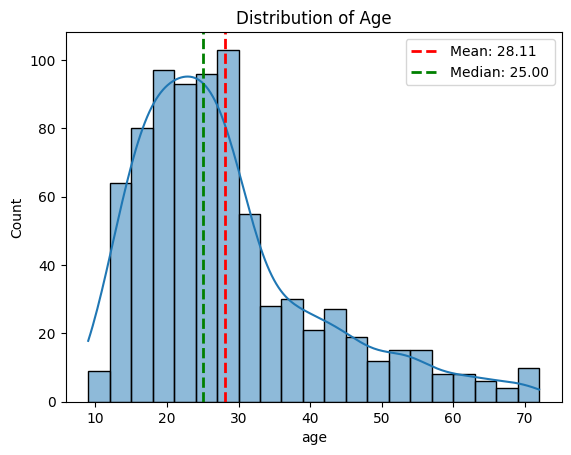

In [20]:
# Histogram for age distribution
sns.histplot(df['age'],kde=True)
plt.title('Distribution of Age')

# calculate mean and median
age_mean = df['age'].mean()
age_median = df['age'].median()

# show it on graph
plt.axvline(age_mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {age_mean:.2f}')
plt.axvline(age_median, color='green', linestyle='dashed', linewidth=2, label=f'Median: {age_median:.2f}')

plt.legend()
plt.show()

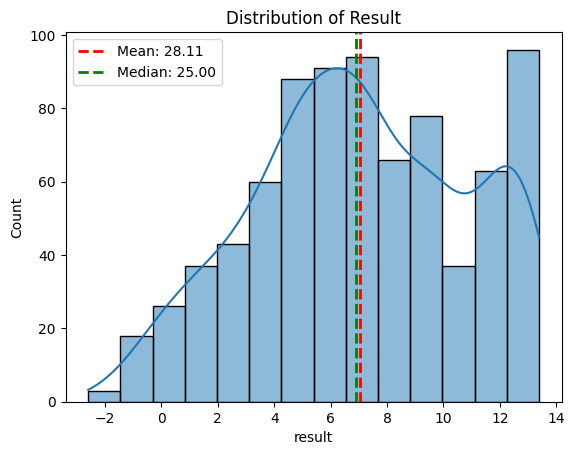

In [21]:
# Histogram for result distribution
sns.histplot(df['result'],kde=True)
plt.title('Distribution of Result')

# calculate mean and median
result_mean = df['result'].mean()
result_median = df['result'].median()

# show it on graph
plt.axvline(result_mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {age_mean:.2f}')
plt.axvline(result_median, color='green', linestyle='dashed', linewidth=2, label=f'Median: {age_median:.2f}')

plt.legend()
plt.show()

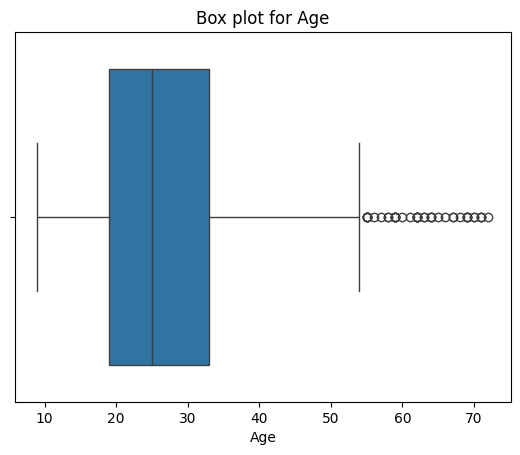

In [22]:
# Boxplot for identifying outlier
sns.boxplot(x=df['age'])
plt.title("Box plot for Age")
plt.xlabel('Age')
plt.show()

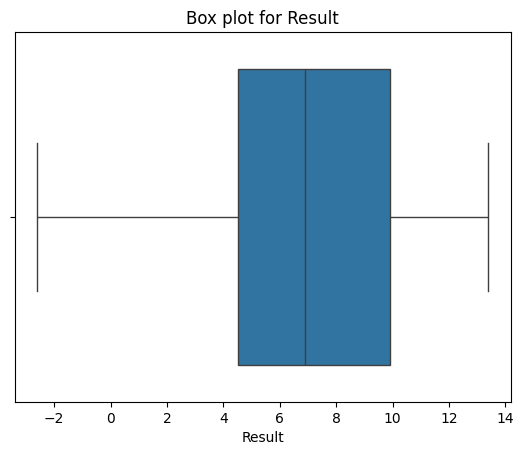

In [23]:
# Boxplot for identifying outlier
sns.boxplot(x=df['result'])
plt.title("Box plot for Result")
plt.xlabel('Result')
plt.show()

In [24]:
# count the number of outliers using IQR
q1 = df['age'].quantile(0.25)
q3 = df['age'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5*iqr
age_outliers = df[(df['age'] < lower_bound) | (df['age'] > upper_bound)]

In [25]:
len(age_outliers)

43

In [26]:
# count the number of outliers using IQR
q1 = df['result'].quantile(0.25)
q3 = df['result'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5*iqr
result_outliers = df[(df['result'] < lower_bound) | (df['result'] > upper_bound)]

In [27]:
len(result_outliers)

0

**Univarient analysis for Categorical coluymns**

In [28]:
df.columns

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender',
       'ethnicity', 'jaundice', 'austim', 'contry_of_res', 'used_app_before',
       'result', 'relation', 'Class/ASD'],
      dtype='object')

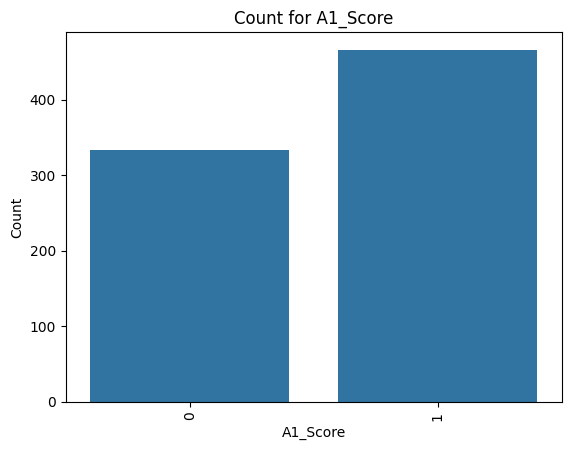

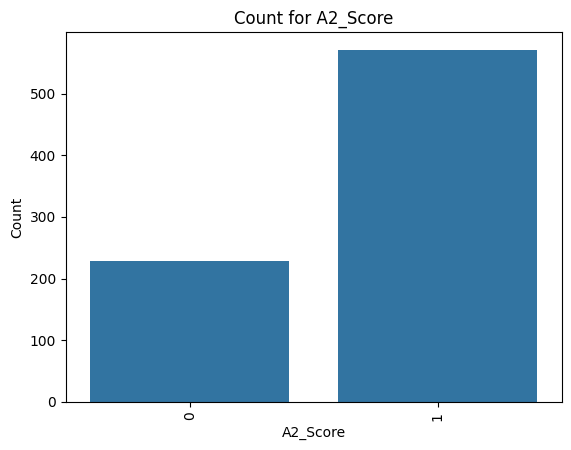

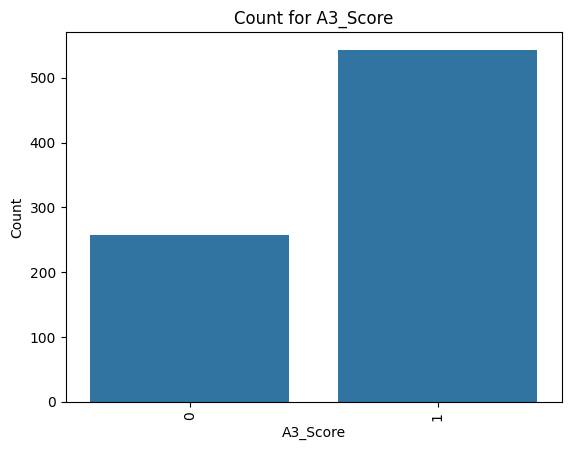

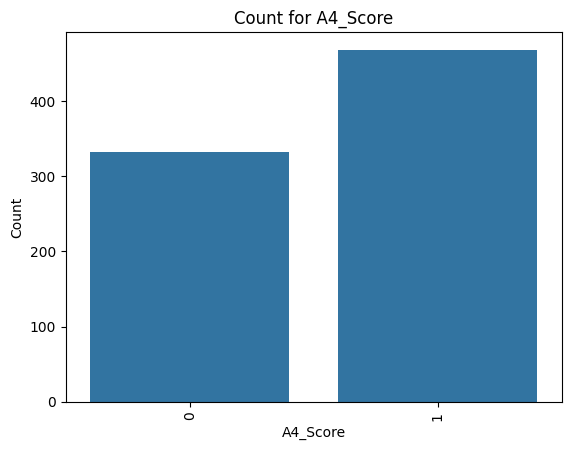

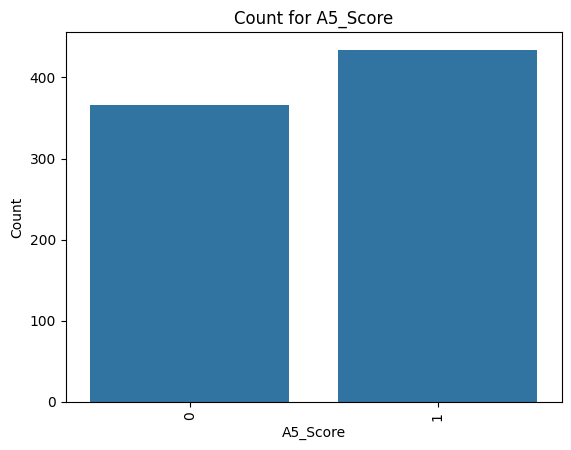

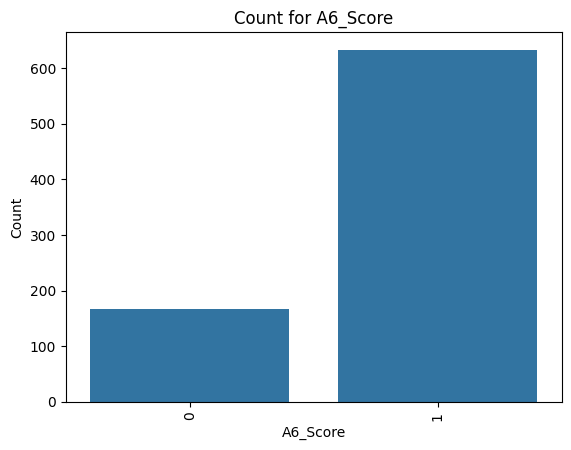

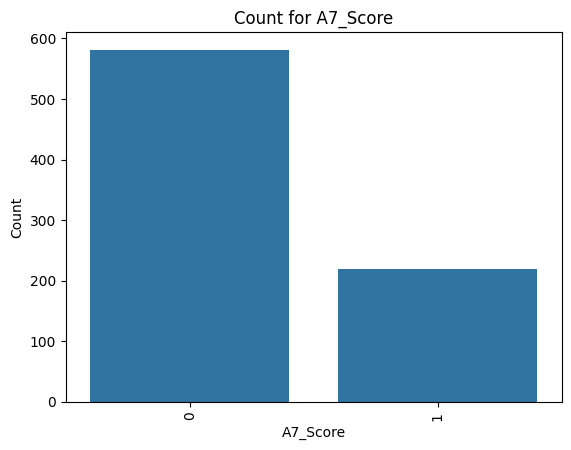

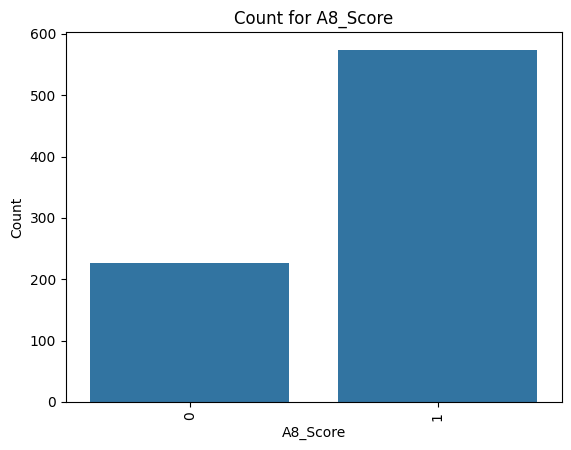

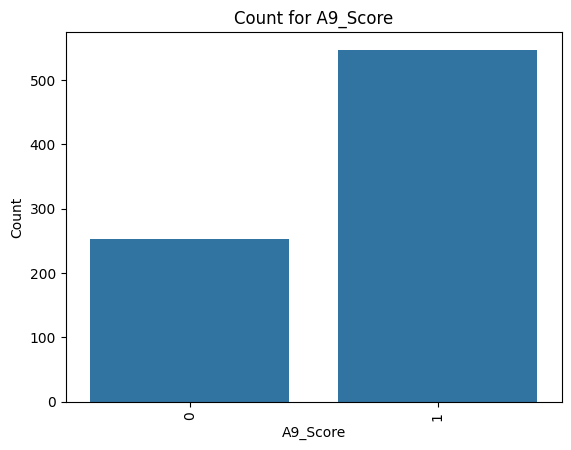

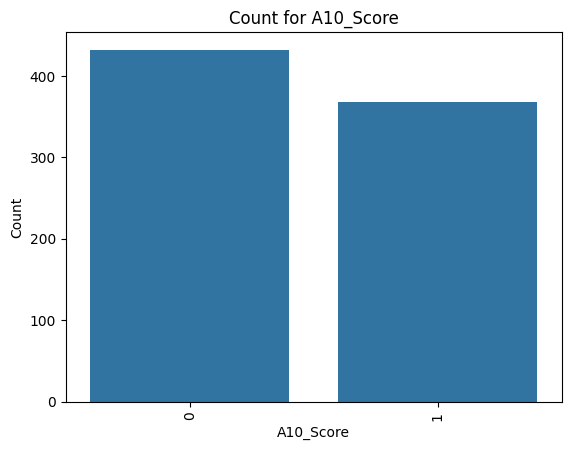

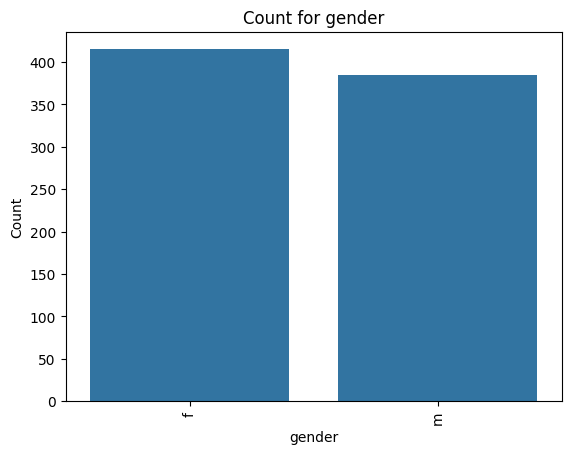

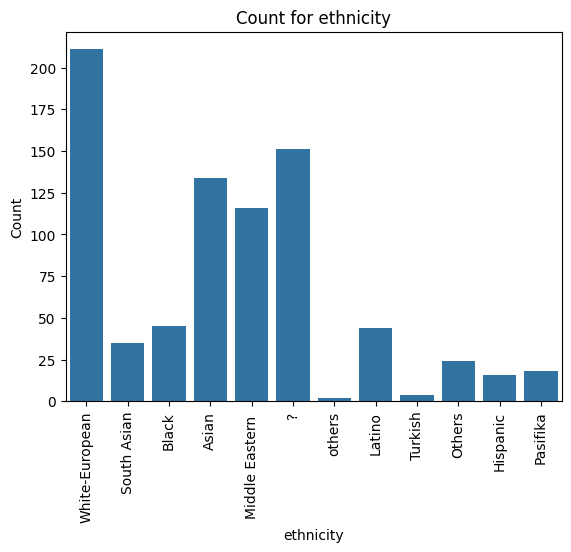

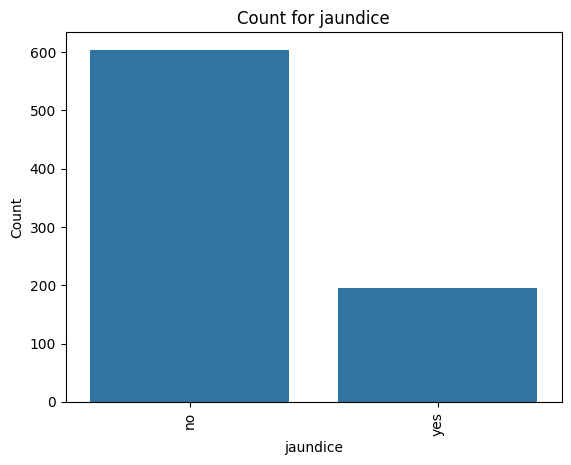

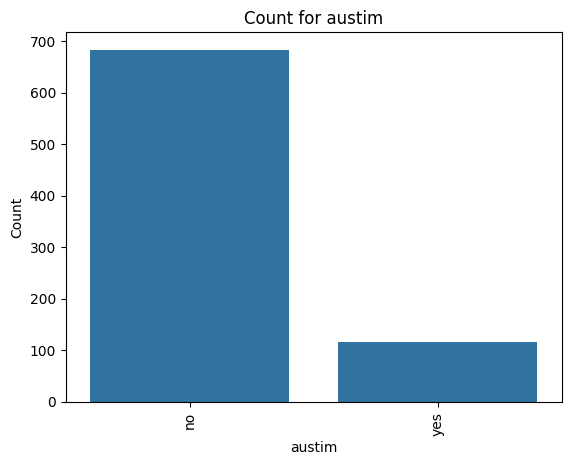

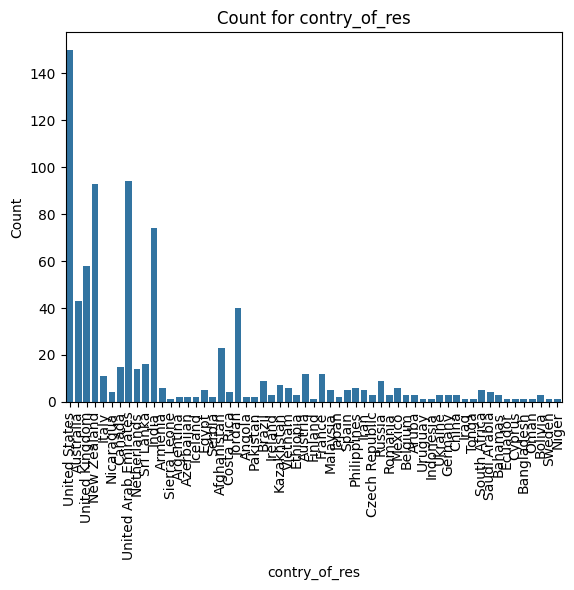

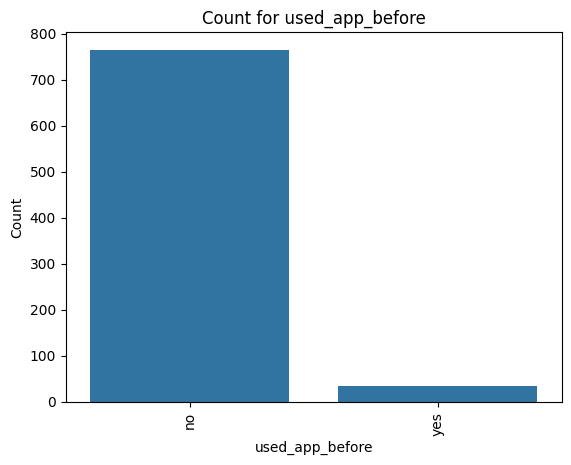

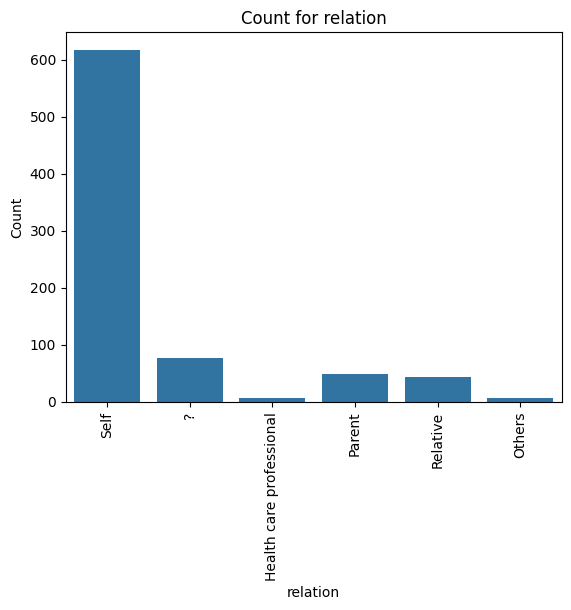

In [29]:
categorical_columns = ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'gender',
       'ethnicity', 'jaundice', 'austim', 'contry_of_res', 'used_app_before','relation']

for col in categorical_columns:
  sns.countplot(x=df[col])
  plt.title(f"Count for {col}")
  plt.xlabel(col)
  plt.ylabel('Count')
  plt.xticks(rotation=90)
  plt.show()

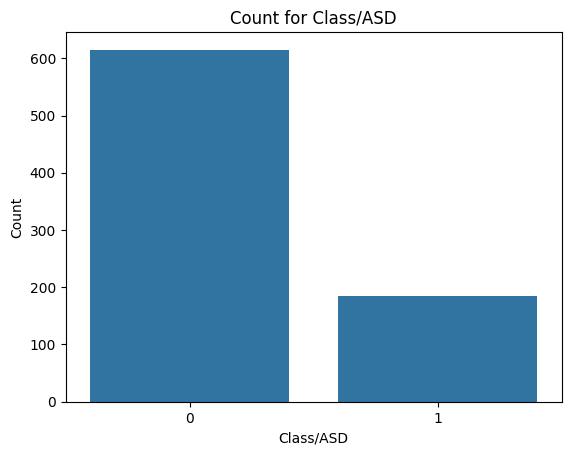

In [30]:
# count plot for target columns
sns.countplot(x=df['Class/ASD'])
plt.title("Count for Class/ASD")
plt.xlabel('Class/ASD')
plt.ylabel('Count')
plt.show()

In [31]:
df['Class/ASD'].value_counts()

,count
Class/ASD,
0,615
1,185


**Handle Missing Values in enthinticity and relation columns**

In [32]:
df['ethnicity'] = df['ethnicity'].replace({'?':'Others','others':'Others'})
df['relation'] = df['relation'].replace(
    {
     '?':'Others',
     'Relative':'Others',
     'Parent':'Others',
     'Health care professional': 'Others'
     }
)

**Label Encoding**

In [33]:
df.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,relation,Class/ASD
0,1,1,0,0,0,0,0,1,0,1,18,f,White-European,no,no,United States,no,7.819715,Self,0
1,0,1,1,1,1,1,0,0,1,1,13,f,South Asian,no,no,Australia,no,10.544296,Others,0
2,1,0,0,0,0,0,0,0,0,1,14,f,White-European,no,no,United Kingdom,no,13.167506,Self,1
3,0,1,1,0,1,1,0,0,1,0,61,f,South Asian,no,no,New Zealand,no,1.530098,Others,0
4,0,1,1,1,0,1,0,0,0,1,14,m,Black,no,yes,Italy,no,7.949723,Self,0


In [34]:
# identify columns with object data type
object_columns = df.select_dtypes(include=['object']).columns

In [35]:
print(object_columns)

Index(['gender', 'ethnicity', 'jaundice', 'austim', 'contry_of_res',
       'used_app_before', 'relation'],
      dtype='object')


In [36]:
# initialize a dictionary to store the encoders
encoders = {}

# apply label enoding and store the encoders
for col in object_columns:
  label_encoder = LabelEncoder()
  df[col] = label_encoder.fit_transform(df[col])
  encoders[col] = label_encoder  # saving the encoder for this column

# save the encoder as a pickle file
with open('encoder.pk1','wb') as f:
  pickle.dump(encoders, f)

In [37]:
df.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,relation,Class/ASD
0,1,1,0,0,0,0,0,1,0,1,18,0,9,0,0,56,0,7.819715,1,0
1,0,1,1,1,1,1,0,0,1,1,13,0,7,0,0,5,0,10.544296,0,0
2,1,0,0,0,0,0,0,0,0,1,14,0,9,0,0,55,0,13.167506,1,1
3,0,1,1,0,1,1,0,0,1,0,61,0,7,0,0,37,0,1.530098,0,0
4,0,1,1,1,0,1,0,0,0,1,14,1,1,0,1,30,0,7.949723,1,0


**Bivarient Analysis**

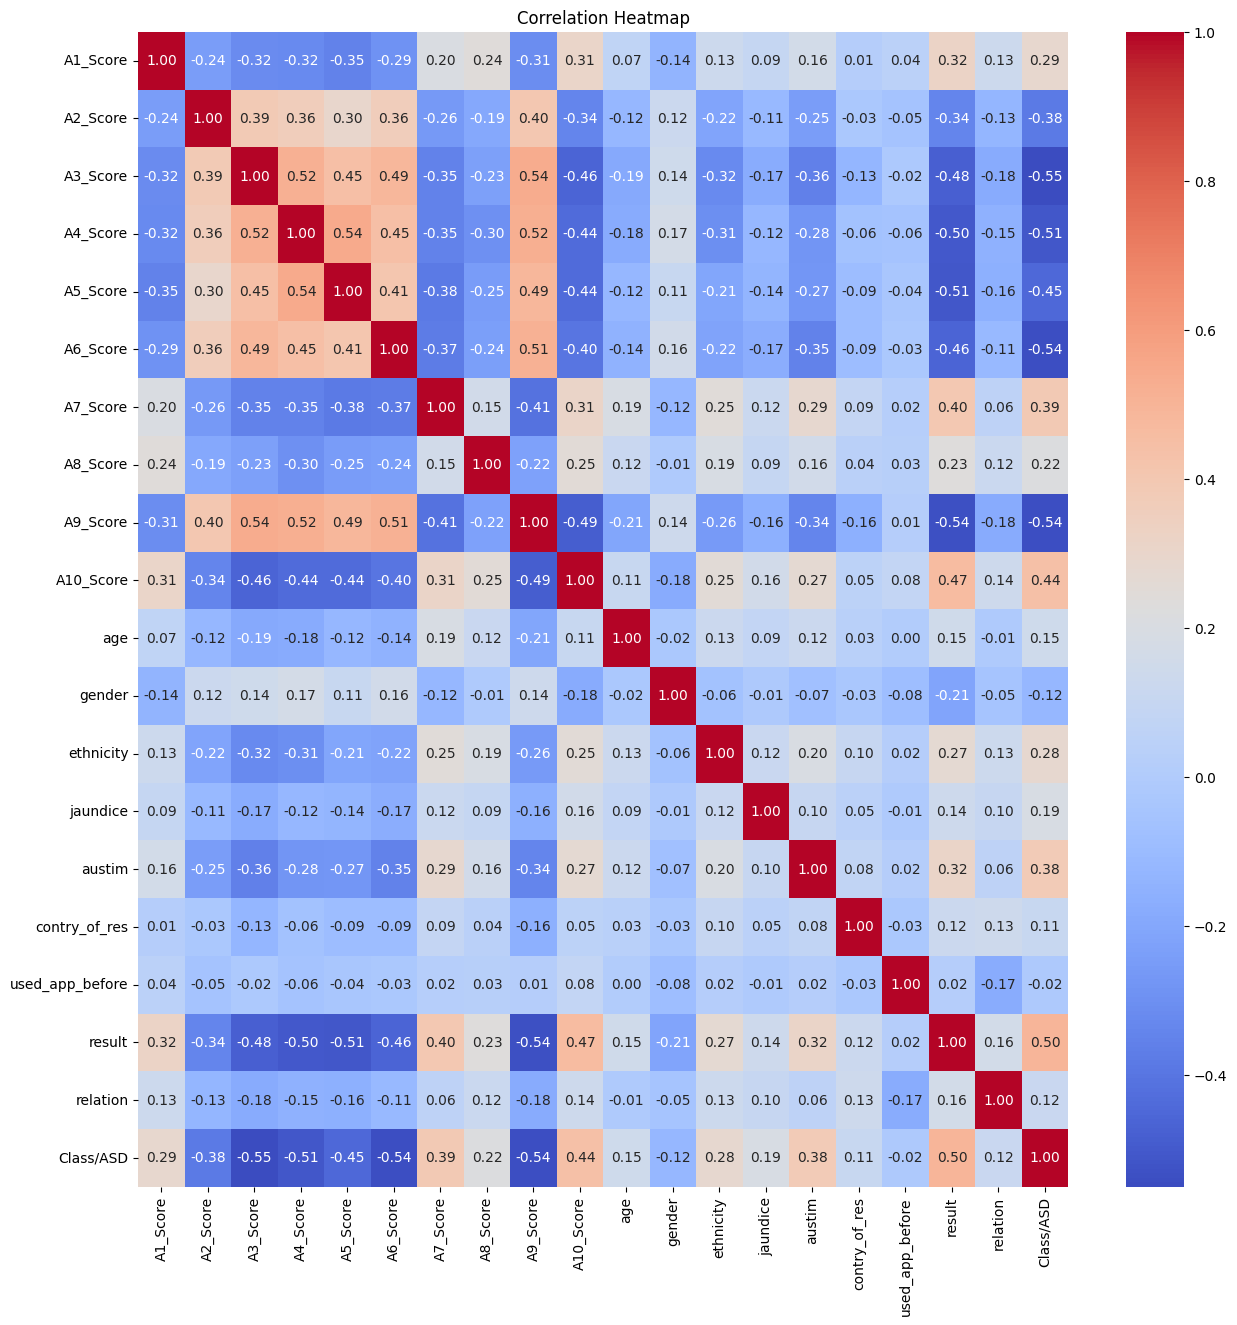

In [38]:
# correlation matrix
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), annot=True,cmap='coolwarm',fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

**Insights from EDA:**
- There are outliers in numerical column age
- There is a class imbalance in target column
- There is a class imbalance in categorical column
we don't have highly correlated columns
- Performed label encoding and saved the encoders

**Data Preprocessing**

In [39]:
# Handling outliers( replace them with median values)
def replace_outliers_with_median(df, col):
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  median = df[col].median()

  # replace outliers with median values
  df[col] = df[col].apply(lambda x: median if x < lower_bound or x > upper_bound else x)
  return df

In [40]:
# replace outliers in the 'age' column
df = replace_outliers_with_median(df, 'age')

**Train-Test Split**

In [41]:
X = df.drop(columns=['Class/ASD'])
y = df['Class/ASD']

In [42]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

**SMOTE - To handle class imbalance**

In [43]:
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=42)
X_train_smote, y_train_smote = smote_tomek.fit_resample(X_train, y_train)

**Model Training**

In [44]:
# Dictionary of classifiers
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42)
}

In [45]:
# dictionary to store the cross validation results
cv_scores = {}

# perform 5-fold cross bvalidation for each model
for model_name,model in models.items():
  print(f"Training {model_name} with default parameters....")
  scores = cross_val_score(model,X_train_smote,y_train_smote,cv=5,scoring="accuracy")
  cv_scores[model_name] = scores
  print(f"{model_name} Cross-Validation Accuracy: {np.mean(scores):.2f}")
  print('*'*60)

Training Decision Tree with default parameters....
Decision Tree Cross-Validation Accuracy: 0.87
************************************************************
Training Random Forest with default parameters....
Random Forest Cross-Validation Accuracy: 0.92
************************************************************
Training XGBoost with default parameters....
XGBoost Cross-Validation Accuracy: 0.91
************************************************************


In [46]:
cv_scores

{'Decision Tree': array([0.79381443, 0.86528497, 0.87564767, 0.90673575, 0.90673575]),
 'Random Forest': array([0.84020619, 0.89119171, 0.95854922, 0.95854922, 0.94300518]),
 'XGBoost': array([0.84020619, 0.88601036, 0.94300518, 0.95336788, 0.93782383])}

**Model selection & Hyper-Parameter Tuning**

In [47]:
# Initializing models
decision_tree = DecisionTreeClassifier(random_state=42)
random_forest = RandomForestClassifier(random_state=42)
xgboost = XGBClassifier(random_state=42)

In [48]:
# Hyperparameter grids for RandomizedSearchCV
decisionTree_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10,20,30,40,50],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,4]
}

randomForest_param_grid = {
    'n_estimators': [50,100,200,500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap':[True,False]
}

xgboost_param_grid = {
    'learning_rate': [0.01,0.1,0.2,0.3],
    'max_depth': [3,5,7,10],
    'n_estimators': [50,100,200,500],
    'subsample': [0.5,0.7,1.0],
    'colsample_bytree': [0.5,0.7,1.0],
    'gamma': [0,0.1,0.2]
}

In [49]:
# Hyperparameter tuning for 3 tree based models

# the below steps can be automated by using a for loop or by using a pipeline

# perfrom randomizedsearch cv
random_search_dt = RandomizedSearchCV(estimator=decision_tree, param_distributions=decisionTree_param_grid, n_iter=20, cv=5, scoring='accuracy', random_state=42)
random_search_rf = RandomizedSearchCV(estimator=random_forest, param_distributions=randomForest_param_grid, n_iter=20, cv=5, scoring='accuracy', random_state=42)
random_search_xgb = RandomizedSearchCV(estimator=xgboost, param_distributions=xgboost_param_grid, n_iter=20, cv=5, scoring='accuracy', random_state=42)

In [50]:
# fit the model
random_search_dt.fit(X_train_smote, y_train_smote)
random_search_rf.fit(X_train_smote, y_train_smote)
random_search_xgb.fit(X_train_smote, y_train_smote)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constrain...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=20,
                   param_distributions={'colsample_bytree': [0.5, 0.7, 1.0],
                                        'gamma': [0, 0.1, 0.2],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [50, 100, 200, 500],
                                        'subsample': [0.5, 0.7, 1.0]},
                   random_state=42, scoring='accuracy')

In [51]:
# get the best model with best score

best_model = None
best_score = 0

if random_search_dt.best_score_ > best_score:
  best_score = random_search_dt.best_score_
  best_model = random_search_dt.best_estimator_

if random_search_rf.best_score_ > best_score:
  best_score = random_search_rf.best_score_
  best_model = random_search_rf.best_estimator_

if random_search_xgb.best_score_ > best_score:
  best_score = random_search_xgb.best_score_
  best_model = random_search_xgb.best_estimator_

In [52]:
print(f"Best Model: {best_model}")
print(f"Best Score: {best_score:.2f}")

Best Model: RandomForestClassifier(max_depth=20, n_estimators=500, random_state=42)
Best Score: 0.92


In [53]:
# save the best model
with open('best_model.pk1','wb') as f:
  pickle.dump(best_model, f)

**Model Evaluation**

In [54]:
# evaluate on test data
y_test_pred = best_model.predict(X_test)
print("Accuracy Score : ",accuracy_score(y_test,y_test_pred))
print("Confusion Matrix : ")
print(confusion_matrix(y_test,y_test_pred))
print("Classification Report : \n",classification_report(y_test,y_test_pred))

Accuracy Score :  0.84375
Confusion Matrix : 
[[104  17]
 [  8  31]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.93      0.86      0.89       121
           1       0.65      0.79      0.71        39

    accuracy                           0.84       160
   macro avg       0.79      0.83      0.80       160
weighted avg       0.86      0.84      0.85       160

